# Train large rnn cross-hemi with switching inputs

In [112]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_models import TwoHemiRNNTanh_asymmetric_single_readout
from dual_alm_rnn_exp import DualALMRNNExp
plt.rcParams['pdf.fonttype'] = '42' 


### three trials

identical noise

In [129]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)


exp.configs['train_type'] = "train_type_modular_fixed_input_cross_hemi"
exp.configs['init_cross_hemi_rel_factor'] = 0.2
exp.configs['random_seed'] = 0
exp.configs['switch_epoch_n'] = 0
exp.configs['n_epochs'] = 30

model = getattr(sys.modules[__name__], configs['model_type'])(exp.configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(exp.configs['train_type'])

checkpoint_file = 'last_model.pth'
# checkpoint_file = 'model_epoch_8.pth'
checkpoint_path = os.path.join(exp.configs['models_dir'], exp.configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

# print(input_weights)
# plt.plot(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())
print(np.sum(np.abs(model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy())), np.sum(np.abs(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())))
model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy()

Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input_cross_hemi/n_neurons_256_random_seed_0/unfix_epoch_0/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/last_model.pth
829.19293 824.4811


array([[ 0.00952305, -0.00558354,  0.0149519 , ..., -0.01862222,
         0.00422327, -0.01607373],
       [ 0.02096389,  0.00326787,  0.00149464, ...,  0.0214002 ,
        -0.00457807, -0.00492747],
       [ 0.00625084,  0.01507902,  0.01423499, ...,  0.0002895 ,
         0.00522823,  0.01621109],
       ...,
       [ 0.01125791, -0.0105628 ,  0.00709759, ..., -0.02684668,
         0.0164278 , -0.00498774],
       [ 0.01335804,  0.04102322,  0.01227029, ...,  0.01554642,
        -0.00653059, -0.0078164 ],
       [-0.01548451,  0.00557383,  0.00396281, ...,  0.00789453,
        -0.00500596, -0.00179927]], dtype=float32)

In [ ]:
# Plot what happens to individual readouts on control vs perturbation trials
import matplotlib.gridspec as gridspec

# start by loading data
train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs_same_noise.npy'))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels.npy'))
# load train inputs and labels


l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)

train_sensory_inputs = torch.tensor(train_sensory_inputs).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input


### After data loading, run model
# no noise: 
# model.train_type = "train_type_modular_fixed_input_cross_hemi_switch"


# For each of the three conditions: control, left alm pert, right alm pert
# for rowidx, (uni_pert, left_pert) in enumerate([
#         (1.0, 1.0),   # Control: both get input
#         (1.0, 0.0),   # Left ALM input
#         (0.0, 1.0)    # Right ALM input
#     ]):

# Set model perturbation parameters for condition
model.return_input = True

# Zero cross hemi weights
# model.rnn_cell.w_hh_linear_lr.weight.data.zero_()
# model.rnn_cell.w_hh_linear_rl.weight.data.zero_()

(left_input, right_input), hs, zs = model(train_sensory_inputs)    # all trials


# - right only: left==0 & right==1

left_first = left_input[:,0,0].cpu().numpy()
right_first = right_input[:,0,0].cpu().numpy()

both_mask = (left_first == 1) & (right_first == 1)
left_only_mask = (left_first == 1) & (right_first == 0)
right_only_mask = (left_first == 0) & (right_first == 1)

# Further divide left_only, right_only, both into "left trial" and "right trial" cases
trials_to_plot = 15

# For 'both' condition, select 5 trials that are "left trial" and 5 that are "right trial"
both_left_trial_inds = [idx for idx in np.where(both_mask)[0] if idx in l_trial_idx][:trials_to_plot]
both_right_trial_inds = [idx for idx in np.where(both_mask)[0] if idx in r_trial_idx][:trials_to_plot]

# For 'left only' condition, select 5 "left trial" and 5 "right trial"
left_only_left_trial_inds = [idx for idx in np.where(left_only_mask)[0] if idx in l_trial_idx][:trials_to_plot]
left_only_right_trial_inds = [idx for idx in np.where(left_only_mask)[0] if idx in r_trial_idx][:trials_to_plot]

# For 'right only' condition, select 5 "left trial" and 5 "right trial"
right_only_left_trial_inds = [idx for idx in np.where(right_only_mask)[0] if idx in l_trial_idx][:trials_to_plot]
right_only_right_trial_inds = [idx for idx in np.where(right_only_mask)[0] if idx in r_trial_idx][:trials_to_plot]

# Store the hs values for these trials for readout plotting below
# Output: Each of these is a (5, T, n_neurons) tensor (if enough trials available)
hs_both_left_trial = hs[both_left_trial_inds]
hs_both_right_trial = hs[both_right_trial_inds]
hs_left_only_left_trial = hs[left_only_left_trial_inds]
hs_left_only_right_trial = hs[left_only_right_trial_inds]
hs_right_only_left_trial = hs[right_only_left_trial_inds]
hs_right_only_right_trial = hs[right_only_right_trial_inds]

hs_both_left_trial_l = hs[both_left_trial_inds][:,:,:model.n_neurons//2].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2])
hs_both_right_trial_l = hs[both_right_trial_inds][:,:,:model.n_neurons//2].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2])
hs_left_only_left_trial_l = hs[left_only_left_trial_inds][:,:,:model.n_neurons//2].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2])
hs_left_only_right_trial_l = hs[left_only_right_trial_inds][:,:,:model.n_neurons//2].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2])
hs_right_only_left_trial_l = hs[right_only_left_trial_inds][:,:,:model.n_neurons//2].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2])
hs_right_only_right_trial_l = hs[right_only_right_trial_inds][:,:,:model.n_neurons//2].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2])

hs_both_left_trial_r = hs[both_left_trial_inds][:,:,model.n_neurons//2:].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:])
hs_both_right_trial_r = hs[both_right_trial_inds][:,:,model.n_neurons//2:].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:])
hs_left_only_left_trial_r = hs[left_only_left_trial_inds][:,:,model.n_neurons//2:].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:])
hs_left_only_right_trial_r = hs[left_only_right_trial_inds][:,:,model.n_neurons//2:].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:])
hs_right_only_left_trial_r = hs[right_only_left_trial_inds][:,:,model.n_neurons//2:].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:])
hs_right_only_right_trial_r = hs[right_only_right_trial_inds][:,:,model.n_neurons//2:].detach().cpu().numpy().dot(model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:])
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex=True, sharey=True)

# Row 0: both, Row 1: left only, Row 2: right only
# Col 0: left hemisphere, Col 1: right hemisphere

# Prepare pairs for plotting and labeling
plot_data = [
    # Row 0: both
    (
        hs_both_left_trial_l, hs_both_right_trial_l,  # left hemi: left trial, right trial
        hs_both_left_trial_r, hs_both_right_trial_r,  # right hemi: left trial, right trial
        "Both inputs"
    ),
    # Row 1: left only
    (
        hs_left_only_left_trial_l, hs_left_only_right_trial_l,
        hs_left_only_left_trial_r, hs_left_only_right_trial_r,
        "Left input only"
    ),
    # Row 2: right only
    (
        hs_right_only_left_trial_l, hs_right_only_right_trial_l,
        hs_right_only_left_trial_r, hs_right_only_right_trial_r,
        "Right input only"
    ),
]

for row, (left_l, right_l, left_r, right_r, condition_label) in enumerate(plot_data):
    # Plot left hemisphere
    ax_left = axs[row, 0]
    for i in range(left_l.shape[0]):
        ax_left.plot(left_l[i], color='red', alpha=0.6, label='Left trial' if i == 0 else None)
    for i in range(right_l.shape[0]):
        ax_left.plot(right_l[i], color='blue', alpha=0.6, label='Right trial' if i == 0 else None)
    if row == 0:
        ax_left.legend()
    ax_left.set_title(f"{condition_label} - Left Hemisphere")
    # Plot right hemisphere
    ax_right = axs[row, 1]
    for i in range(left_r.shape[0]):
        ax_right.plot(left_r[i], color='red', alpha=0.6, label='Left trial' if i == 0 else None)
    for i in range(right_r.shape[0]):
        ax_right.plot(right_r[i], color='blue', alpha=0.6, label='Right trial' if i == 0 else None)
    if row == 0:
        ax_right.legend()
    ax_right.set_title(f"{condition_label} - Right Hemisphere")

for ax in axs[-1,:]:
    ax.set_xlabel('Time')

for ax in axs[:,0]:
    ax.set_ylabel('Neuron activation')
plt.suptitle(f'Cross Hemisphere Weight = {exp.configs["init_cross_hemi_rel_factor"]}, mixed switching')
plt.tight_layout()
plt.show()




In [117]:
print(sum(both_mask), sum(left_only_mask), sum(right_only_mask))

1234 1219 1311


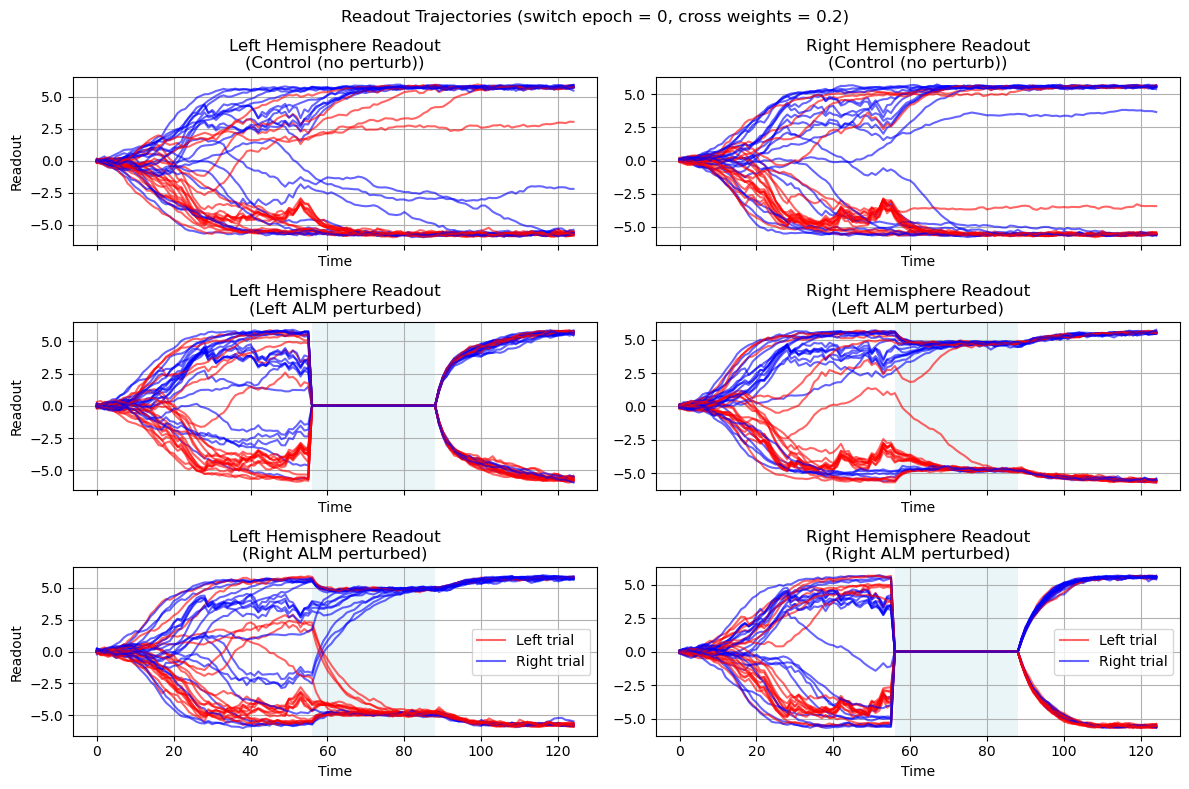

In [127]:
# Plot what happens to individual readouts on control vs perturbation trials
import matplotlib.gridspec as gridspec

# start by loading data
train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs_same_noise.npy' ))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels.npy'))
# load train inputs and labels

train_sensory_inputs.shape, train_trial_type_labels.shape

l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input


### After data loading, run model # with no noise:
# model.train_type = "train_type_modular_fixed_input_cross_hemi"


# Pass input into model
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)  # 3 conditions, 2 hemispheres

# Define condition names for labeling
condition_names = [
    "Control (no perturb)", 
    "Left ALM perturbed", 
    "Right ALM perturbed"
]
# For legend management
line_objs = [[None, None] for _ in range(3)]

# For each of the three conditions: control, left alm pert, right alm pert
for rowidx, (uni_pert, left_pert) in enumerate([
        (0.0, 0.5),   # Control: no perturb
        (1.0, 1.0),   # Left ALM perturbed
        (1.0, 0.0)    # Right ALM perturbed
    ]):

    # Set model perturbation parameters for condition
    model.uni_pert_trials_prob = uni_pert
    model.left_alm_pert_prob = left_pert
    _, hs_l, zs_l = model(l_trial_input_all)    # left trial
    _, hs_r, zs_r = model(r_trial_input_all)    # right trial

    for i in range(20):
        # l_trial_input = l_trial_input_all[i].reshape(1, exp.T, 2)
        # r_trial_input = r_trial_input_all[i].reshape(1, exp.T, 2)

        # Compute left and right readouts for left and right trials
        left_readout_l = hs_l[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_l = hs_l[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        left_readout_r = hs_r[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_r = hs_r[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        # Left hemisphere readout subplot (col 0)
        l_line = axs[rowidx,0].plot(left_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line = axs[rowidx,0].plot(left_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][0] = (l_line[0], r_line[0])

        # Right hemisphere readout subplot (col 1)
        l_line2 = axs[rowidx,1].plot(right_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line2 = axs[rowidx,1].plot(right_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][1] = (l_line2[0], r_line2[0])

    # Add light blue bar (span) for perturbation period on perturbation subplots
    # Only add for perturbed conditions (rowidx 1 and 2)
    if rowidx in [1, 2]:
        # perturbation likely in delay epoch; use exp.delay_begin, exp.T for x-range
        axs[rowidx,0].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)
        axs[rowidx,1].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)

    # Titles, labels for each row
    axs[rowidx,0].set_title(f"Left Hemisphere Readout\n({condition_names[rowidx]})" )
    axs[rowidx,1].set_title(f"Right Hemisphere Readout\n({condition_names[rowidx]})")
    axs[rowidx,0].set_ylabel("Readout")
    axs[rowidx,0].set_xlabel("Time")
    axs[rowidx,1].set_xlabel("Time")
    axs[rowidx,0].grid()
    axs[rowidx,1].grid()

# Only show legend in the bottom row for both hemispheres (col 0/col 1)
for col in range(2):
    axs[-1,col].legend()

plt.suptitle(f'Readout Trajectories (switch epoch = {exp.configs["switch_epoch_n"]}, cross weights = {exp.configs["init_cross_hemi_rel_factor"]})')
plt.tight_layout()
plt.show()




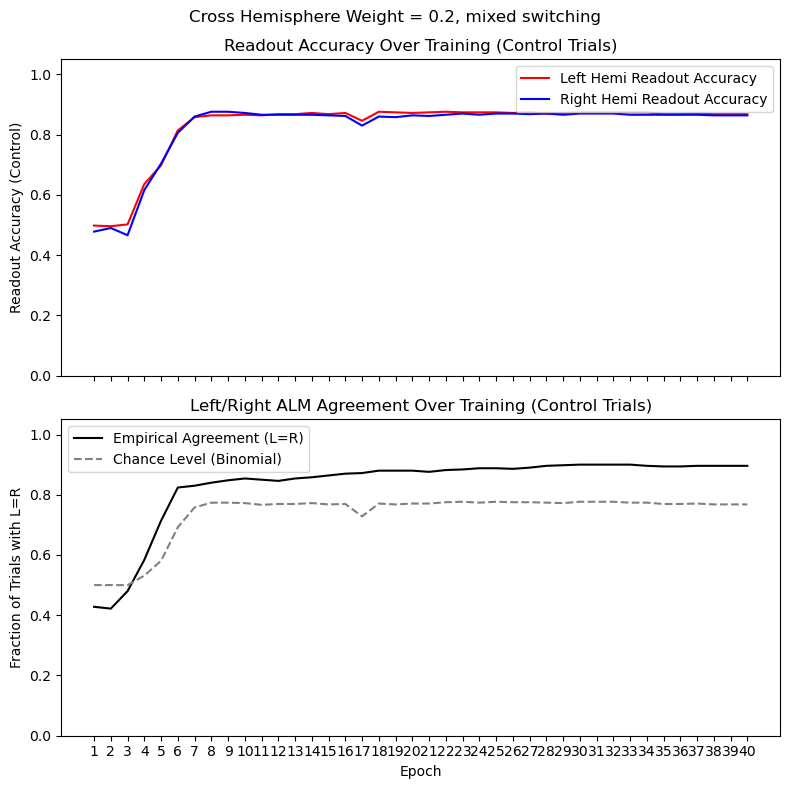

In [111]:

checkpoint_file = 'all_val_results_dict.npy'
checkpoint_path = os.path.join(configs['logs_dir'], configs['model_type'], exp.sub_path, checkpoint_file)

results_dict = np.load(checkpoint_path, allow_pickle=True)

epochs = np.arange(1, len(results_dict) + 1)
readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

# time_to_reach.append(np.where(readout_acc_left > 0.9)[0][0])
# time_to_reach_right.append(np.where(readout_acc_right > 0.9)[0][0])


n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
agreement_frac = n_trials_agreed / n_trials

# Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

corruption_start_epoch = exp.configs['corruption_start_epoch']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top subplot: Readout accuracies
ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax1.set_ylabel('Readout Accuracy (Control)')
ax1.set_title('Readout Accuracy Over Training (Control Trials)')
ax1.set_xticks(epochs)
ax1.set_ylim(0, 1.05)
ax1.legend() 

# Bottom subplot: Agreement
ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Fraction of Trials with L=R')
ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
ax2.set_xticks(epochs)
ax2.set_ylim(0, 1.05)
ax2.legend()
# plt.xlim(0,20)

plt.suptitle(f'Cross Hemisphere Weight = {exp.configs["init_cross_hemi_rel_factor"]}, mixed switching')

plt.tight_layout()

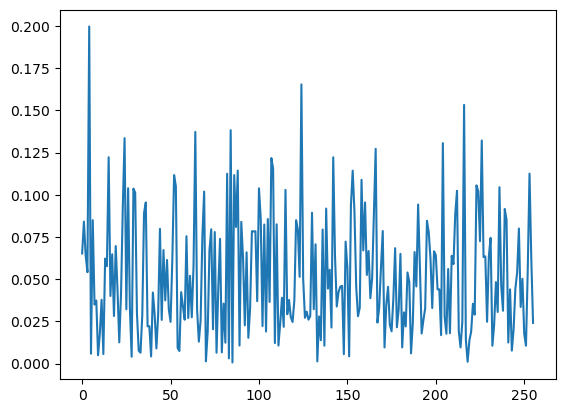

In [75]:
plt.plot(np.abs(model.readout_linear.weight.data.cpu().numpy()[0,:]))
# model.readout_linear.weight.data.cpu().numpy().shape